# Get from Address to Model

In [4]:
import urllib
import requests
import json

## Geo-Admin API
Access of the API

In [5]:
#Definition of parameters
text = input("Please enter an address: ") #Input of the address to search for
base_url="https://api3.geo.admin.ch/rest/services/api/SearchServer?"
parameters = {"searchText": text, "origins": "address", "type": "locations",}

#Request
r = requests.get(f"{base_url}{urllib.parse.urlencode(parameters)}")

data = json.loads(r.content)
#print(data)

Geographic display of returned results

In [6]:
import folium

# Create a map centered at the first item's latitude and longitude
map_center = [data['results'][0]['attrs']['lat'], data['results'][0]['attrs']['lon']]
m = folium.Map(location=map_center, zoom_start=20)

# Add markers for each item with annotations
for i, result in enumerate(data['results']):
    lat = result['attrs']['lat']
    lon = result['attrs']['lon']
    label = f"Index: {i}"
    folium.Marker([lat, lon], popup=label).add_to(m)

# Display the map
m


In [7]:
#Select the desired item
index = int(input("Please enter the index of the item you want to select: "))
selected_building = data['results'][index]
#print(selected_building)


## KML files
Check KML files for desired building

In [8]:
import os
import re
import math

# Define the folder path
folder_path = "swissBUILDINGS3D"

# Get the latitude and longitude from the selected_item
lat = float(selected_building['attrs']['lat'])
lon = float(selected_building['attrs']['lon'])
print(f"Latitude: {lat}", f"Longitude: {lon}")

# Define the calculate_distance function
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert coordinates to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = 6371 * c  # Earth radius in kilometers

    return distance

# Search for KML files in the folder
kml_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".kml"):
            kml_files.append(os.path.join(root, file))

print(f"Found {len(kml_files)} KML files", kml_files)

# Define the tolerance in kilometers
tolerance = 0.01

# List to store the filtered KML data
filtered_kml_data = []
lat_kml = None
lon_kml = None

# Iterate through the KML files
for kml_file in kml_files:
    with open(kml_file, 'r') as file:
        kml_content = file.read()
        
        # Extract the latitude and longitude values from the KML content
        latitudes = re.findall(r'<latitude>(.*?)</latitude>', kml_content)
        longitudes = re.findall(r'<longitude>(.*?)</longitude>', kml_content)
        hrefs = re.findall(r'<href>(.*?)</href>', kml_content)
        
        # Convert the latitude and longitude values to float
        latitudes = [float(lat) for lat in latitudes]
        longitudes = [float(lon) for lon in longitudes]
        
        # Check if any entry is within the tolerance
        for i in range(len(latitudes)):
            distance = calculate_distance(lat, lon, latitudes[i], longitudes[i])
            if distance <= tolerance:
                filtered_kml_data.append((kml_file, latitudes[i], longitudes[i],  hrefs[i]))
                lat_kml = latitudes[i]
                lon_kml = longitudes[i]

# Print the filtered KML data
#for data in filtered_kml_data:
    #print(f"KML File: {data[0]}, Latitude: {data[1]}, Longitude: {data[2]}, href: {data[3]}")



Latitude: 47.63404846191406 Longitude: 8.694016456604004
Found 6 KML files ['swissBUILDINGS3D\\1031-44\\1031-44.kml', 'swissBUILDINGS3D\\1032-33\\1032-33.kml', 'swissBUILDINGS3D\\1032-34\\1032-34.kml', 'swissBUILDINGS3D\\1051-22\\1051-22.kml', 'swissBUILDINGS3D\\1052-11\\1052-11.kml', 'swissBUILDINGS3D\\1052-12\\1052-12.kml']


## Get model data from kml

In [9]:
import collada

kml = filtered_kml_data[0][0].split("\\")[1]
model = filtered_kml_data[0][3].split("/")[-1]

print(model, kml)

for data in filtered_kml_data:
    kml_file = data[0]
    lat = data[1]
    lon = data[2]
    href = data[3]
    
    # Load the COLLADA file
    coll = collada.Collada("swissBUILDINGS3D\\"+kml+"\\models\\"+model)
    #print ("swissBUILDINGS3D\\"+kml+"\\models\\"+model)
    # Extract the geometry
    #print(coll)
    #print(coll.geometries)
    #print(coll.geometries[0].primitives)
    #for i in coll.geometries[0].primitives[0]:
        #print(i)


model_2045.dae 1052-11


In [10]:
import numpy as np
from ipygany import PolyMesh

meshes=[]

for i in range(len(coll.geometries)):
    
    vertices = []
    faces = []

    for triangle in coll.geometries[i].primitives[0]:
        # Extract the vertices of the triangle
        v1, v2, v3 = triangle.vertices
        
        # Add the vertices to the vertices list
        vertices.append(v1)
        vertices.append(v2)
        vertices.append(v3)
        
        # Calculate the indices of the vertices in the faces list
        index1 = len(vertices) - 3
        index2 = len(vertices) - 2
        index3 = len(vertices) - 1
        
        # Add the indices to the faces list
        faces.append([index1, index2, index3])

    # Convert the vertices and faces lists to numpy arrays
    vertices = np.array(vertices)
    faces = np.array(faces)

    # Create the PolyMesh
    mesh = PolyMesh(vertices=vertices, triangle_indices=faces)
    meshes.append(mesh)

#print(meshes[0].vertices)


In [11]:
#Draw the whole building
from ipygany import Scene

sceneHouse = Scene(meshes)
sceneHouse

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [12]:
walls = [mesh for mesh in meshes if (mesh.vertices[2::3].max()- mesh.vertices[2::3].min())> 6]

sceneWalls = Scene(walls)
sceneWalls


Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [13]:
roof = [mesh for mesh in meshes if not (mesh.vertices[2::3].max()- mesh.vertices[2::3].min())> 6]

sceneRoof = Scene(roof)
sceneRoof

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [14]:
num_triangles = len(walls[0].vertices)/9
ns_walls, we_walls = [], []
ns_vertices, we_vertices = [], []
ns_faces, we_faces = [], []
triangles = []
ns_index=0
we_index=0
for i in range(int(num_triangles)):
    triangle= walls[0].vertices[i*9:(i+1)*9]
    triangles.append(triangle)
for triangle in triangles:
    x1, y1, z1 = triangle[0], triangle[1], triangle[2]
    x2, y2, z2 = triangle[3], triangle[4], triangle[5]
    x3, y3, z3 = triangle[6], triangle[7], triangle[8]

    dir12 = np.array([abs(x2 - x1), abs(y2 - y1)])
    dir13 = np.array([abs(x3 - x1), abs(y3 - y1)])
    dir23 = np.array([abs(x3 - x2), abs(y3 - y2)])

    if(max(dir12[0], dir13[0], dir23[0])>max(dir12[1],dir13[1],dir23[1])):
        ns_vertices.append(triangle)
        ns_faces.append([ns_index, ns_index+1, ns_index+2])
        ns_index+=3

    else:
        we_vertices.append(triangle)
        we_faces.append([we_index, we_index+1, we_index+2])
        we_index+=3

ns_walls.append(PolyMesh(vertices=ns_vertices, triangle_indices=ns_faces))
we_walls.append(PolyMesh(vertices=we_vertices, triangle_indices=we_faces))

print(we_walls)

sceneNS =Scene(we_walls)
sceneNS


[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), vertices=array([ 5.4050426e+00, -4.5410995e+00,  4.7864801e+02,  5.4050426e+00,
       -4.5410995e+00,  4.6933499e+02,  3.9541759e+00, -1.1537193e+00,
        4.7996100e+02,  3.9541759e+00, -1.1537193e+00,  4.7996100e+02,
        2.3208126e-01,  7.5382614e+00,  4.6933499e+02,  2.3208126e-01,
        7.5382614e+00,  4.7630200e+02,  5.4050426e+00, -4.5410995e+00,
        4.6933499e+02,  2.3208126e-01,  7.5382614e+00,  4.6933499e+02,
        3.9541759e+00, -1.1537193e+00,  4.7996100e+02, -3.5379400e+00,
        5.9235096e+00,  4.7630200e+02, -2.1757424e+00,  2.7445581e+00,
        4.6933499e+02, -2.1757424e+00,  2.7445581e+00,  4.7764099e+02,
       -3.5379400e+00,  5.9235096e+00,  4.6933499e+02, -2.1757424e+00,
        2.7445581e+00,  4.6933499e+02, -3.5379400e+00,  5.9235096e+00,
        4.7630200e+02, -5.4050355e+00,  1.3611650e+00,  4.7764

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [15]:
wallsNS2D, wallsWE2D = [], []
for i in range(len(ns_walls[0].vertices)):
    if not i % 3 == 2:
        wallsNS2D.append(ns_walls[0].vertices[i])

for i in range(len(we_walls[0].vertices)):
    if not i % 3 == 2:
        wallsWE2D.append(we_walls[0].vertices[i])


print(wallsNS2D)
print(wallsWE2D)

[0.23208126, 7.5382614, -3.53794, 5.9235096, -3.53794, 5.9235096, 0.23208126, 7.5382614, -3.53794, 5.9235096, 0.23208126, 7.5382614, -2.1757424, 2.744558, -2.1757424, 2.744558, -5.4050355, 1.361165, -2.1757424, 2.744558, -5.4050355, 1.361165, -5.4050355, 1.361165, -1.5932719, -7.5392604, 5.4050426, -4.5410995, 5.4050426, -4.5410995, -1.5932719, -7.5392604, -1.5932719, -7.5392604, 5.4050426, -4.5410995]
[5.4050426, -4.5410995, 5.4050426, -4.5410995, 3.954176, -1.1537193, 3.954176, -1.1537193, 0.23208126, 7.5382614, 0.23208126, 7.5382614, 5.4050426, -4.5410995, 0.23208126, 7.5382614, 3.954176, -1.1537193, -3.53794, 5.9235096, -2.1757424, 2.744558, -2.1757424, 2.744558, -3.53794, 5.9235096, -2.1757424, 2.744558, -3.53794, 5.9235096, -5.4050355, 1.361165, -5.4050355, 1.361165, -3.0441387, -4.1518803, -3.0441387, -4.1518803, -1.5932719, -7.5392604, -1.5932719, -7.5392604, -5.4050355, 1.361165, -1.5932719, -7.5392604, -3.0441387, -4.1518803]


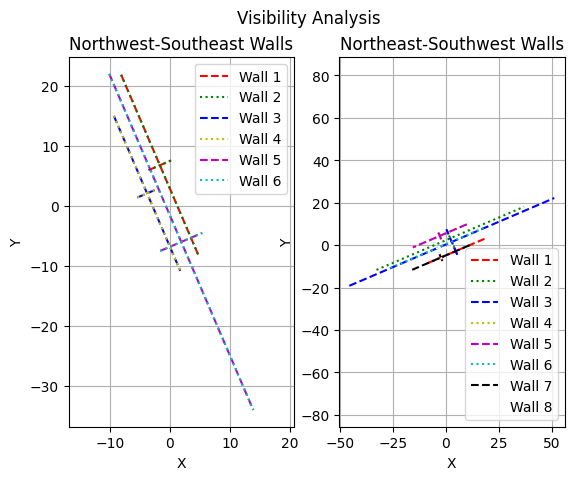

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [16]:
from math import isclose
import matplotlib.pyplot as plt

n_walls, e_walls, s_walls, w_walls = [], [], [], []
n_walls_vertices, e_walls_vertices, s_walls_vertices, w_walls_vertices = [], [], [], []
vectorsNS=[]
vectorsWE=[]
color=['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w']
styles=['dashed',  'dotted']

for i in range(0, len(wallsNS2D), 6):
    x1, y1, x2, y2, x3, y3 = wallsNS2D[i], wallsNS2D[i+1], wallsNS2D[i+2], wallsNS2D[i+3], wallsNS2D[i+4], wallsNS2D[i+5]
    x=min(x1, x2, x3)
    if x1==x:
        y=y1
        dx = max(x2, x3)-x1
        dy = max(y2, y3)-y1
    elif x2==x:
        y=y2
        dx = max(x1, x3)-x2
        dy = max(y1, y3)-y2
    else:
        y=y3
        dx = max(x1, x2)-x3
        dy = max(y1, y2)-y3
    vectorsNS.append([x, y, dx, dy])
    
for i in range(0, len(wallsWE2D), 6):
    x1, y1, x2, y2, x3, y3 = wallsWE2D[i], wallsWE2D[i+1], wallsWE2D[i+2], wallsWE2D[i+3], wallsWE2D[i+4], wallsWE2D[i+5]
    if (x1 != x2):
        dx = x2-x1
        dy = y2-y1
    else:
        dx = x3-x1
        dy = y3-y1
    vectorsWE.append([x1, y1, dx, dy])

def intersection(s1 , s2):
    m1, c1 = s1
    m2, c2 = s2

    if m1 == m2:
        return None
    else:
        x= (c2-c1)/(m1-m2)
        y= m1*x+c1
        return (x, y)

def check_triangle_exists(array, triangle):
    for i in range(0, len(array),9):
        current_triangle = array[i:i+9]
        if np.array_equal(current_triangle,triangle):
            return True
    return False

plt.subplot(1,2,1)
for i in range(len(vectorsNS)):
    x1, y1, dx, dy = vectorsNS[i]
    if dy==0:
        vector90=0
    elif dx==0:
        vector90=1000 #arbitrary large number, due to infinite slope
    else:
        vector90= -dx/dy
    xmid, ymid = x1+dx/2, y1+dy/2
    straight = (vector90, ymid - vector90*xmid)
    straightmax = (vector90, (y1+dy)- vector90*(x1+dx)-0.02)
    straightmin = (vector90, y1- vector90*x1+0.02)
    plt.plot([x1, x1+dx], [y1, y1+dy], color[i%len(color)], label=f"Wall {i+1}", linestyle=styles[i%2])
    plt.plot([xmid-(dy*4), xmid+(dy*4)], [ymid-(-dx*4), ymid+(-dx*4)], color[i%len(color)], linestyle=styles[i%2])   
    if check_triangle_exists(n_walls_vertices, ns_walls[0].vertices[i*9: i*9+9]) or check_triangle_exists(s_walls_vertices, ns_walls[0].vertices[i*9: i*9+9]):
            #print("Triangle already exists")
            continue
    
    for j in range(i+1, len(vectorsNS)):
        ox1, oy1, odx, ody = vectorsNS[j]
        s2= (ody/odx, oy1-ody/odx*ox1)
        #plt.plot([ox1, ox1+odx], [oy1, oy1+ody], color[j%len(color)], label=f"Wall J {j+1}")
        if intersection(straight, s2) == None:
            continue
        elif isclose(intersection(straight, s2)[0], xmid, rel_tol=1e-2) and isclose(intersection(straight, s2)[1],ymid,rel_tol=1e-2):
            #print("Same wall")
            continue
        elif intersection(straight, s2)[1]>ymid and intersection(straight,s2)[0]<=max(ox1, ox1+odx) and intersection(straight,s2)[0]>=min(ox1,ox1+odx): #if there is a wall further north
            #print("wall further north: ",i, i+j, xmid, ymid, intersection(straight, s2))
            s_walls_vertices.extend(ns_walls[0].vertices[i*9: i*9+9])
            n_walls_vertices.extend(ns_walls[0].vertices[(i+j)*9: (i+j)*9+9])
            continue
        elif intersection(straight, s2)[1]<ymid and intersection(straight,s2)[0]<=max(ox1,ox1+odx) and intersection(straight,s2)[0]>=min(ox1,ox1+odx): #if there is a wall further south
            #print("wall further south: ",i, i+j, xmid, ymid, intersection(straight, s2))
            n_walls_vertices.extend(ns_walls[0].vertices[i*9: i*9+9])
            s_walls_vertices.extend(ns_walls[0].vertices[(i+j)*9: (i+j)*9+9])
            continue
        else:
            if isclose(intersection(straightmax, s2)[1], x1+dx, rel_tol=1e-2) and isclose(intersection(straightmax, s2)[1],y1+dy,rel_tol=1e-2) or isclose(intersection(straightmin, s2)[0], x1, rel_tol=1e-2) and isclose(intersection(straightmin, s2)[1],y1,rel_tol=1e-2):
                #print("Same wall")
                continue
            elif intersection(straightmax, s2)[1]>xmid and intersection(straightmax,s2)[0]<=max(ox1, ox1+odx) and intersection(straightmax,s2)[0]>=min(ox1, ox1+odx):
                #print("wall further east: ",i, j, xmid, ymid, intersection(straightmax, s2))
                w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmax, s2)[1]<xmid and intersection(straightmax,s2)[0]<=max(ox1, ox1+odx) and intersection(straightmax,s2)[0]>=min(ox1, ox1+odx):
                #print("wall further west: ",i, j, xmid, ymid, intersection(straightmax, s2))
                e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmin, s2)[1]>xmid and intersection(straightmin,s2)[0]<=max(ox1, ox1+odx) and intersection(straightmin,s2)[0]>=min(ox1, ox1+odx):
                #print("wall further east: ",i, j, xmid, ymid, intersection(straightmin, s2))
                w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmin, s2)[1]<xmid and intersection(straightmin,s2)[0]<=max(ox1, ox1+odx) and intersection(straightmin,s2)[0]>=min(ox1, ox1+odx):
                #print("wall further west: ",i, j, xmid, ymid, intersection(straightmin, s2))
                e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
            else:
                #print("No intersection")
                continue

    #print ("")
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Northwest-Southeast Walls")
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.subplot(1,2,2)
for i in range(len(vectorsWE)):
    x1, y1, dx, dy = vectorsWE[i]
    if dy==0:
        vector90=0
    elif dx==0:
        vector90=1000 #arbitrary large number, due to infinite slope
    else:
        vector90= -dx/dy
    xmid, ymid = x1+dx/2, y1+dy/2
    straight = (vector90, ymid - vector90*xmid)
    straightmax = (vector90, (y1+dy)- vector90*(x1+dx)+0.02)
    straightmin = (vector90, y1- vector90*x1-0.02)
    plt.plot([x1, x1+dx], [y1, y1+dy], color[i%len(color)], label=f"Wall {i+1}", linestyle=styles[i%2])
    plt.plot([xmid-(dy*4), xmid+(dy*4)], [ymid-(-dx*4), ymid+(-dx*4)], color[i%len(color)], linestyle=styles[i%2])   
    if check_triangle_exists(w_walls_vertices, we_walls[0].vertices[i*9: i*9+9]) or check_triangle_exists(e_walls_vertices, we_walls[0].vertices[i*9: i*9+9]):
            #print("Triangle already exists")
            continue
    
    for j in range(len(vectorsWE)):
        if i==j:
            continue
        ox1, oy1, odx, ody = vectorsWE[j]
        s2= (ody/odx, oy1-ody/odx*ox1)
        if intersection(straight, s2) == None:
            continue
        elif isclose(intersection(straight, s2)[0], xmid, rel_tol=1e-2) and isclose(intersection(straight, s2)[1],ymid,rel_tol=1e-2):
            #print("Same wall")
            continue
        elif intersection(straight, s2)[0]>xmid and intersection(straight,s2)[1]<=max(oy1, oy1+ody) and intersection(straight,s2)[1]>=min(oy1,oy1+ody):
            #print("wall further east: ",i, j, xmid, ymid, intersection(straight, s2))
            w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
            e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
            continue
        elif intersection(straight, s2)[0]<xmid and intersection(straight,s2)[1]<=max(oy1,oy1+ody) and intersection(straight,s2)[1]>=min(oy1,oy1+ody):
            #print("wall further west: ",i, j, xmid, ymid, intersection(straight, s2))
            e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
            w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
            continue
        else:
            if isclose(intersection(straightmax, s2)[0], x1+dx, rel_tol=1e-2) and isclose(intersection(straightmax, s2)[1],y1+dy,rel_tol=1e-2) or isclose(intersection(straightmin, s2)[0], x1, rel_tol=1e-2) and isclose(intersection(straightmin, s2)[1],y1,rel_tol=1e-2):
                #print("Same wall")
                continue
            elif intersection(straightmax, s2)[0]>xmid and intersection(straightmax,s2)[1]<=max(oy1, oy1+ody) and intersection(straightmax,s2)[1]>=min(oy1,oy1+ody):
                #print("wall further east: ",i, j, xmid, ymid, intersection(straightmax, s2))
                w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmax, s2)[0]<xmid and intersection(straightmax,s2)[1]<=max(oy1,oy1+ody) and intersection(straightmax,s2)[1]>=min(oy1,oy1+ody):
                #print("wall further west: ",i, j, xmid, ymid, intersection(straightmax, s2))
                e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmin, s2)[0]>xmid and intersection(straightmin,s2)[1]<=max(oy1, oy1+ody) and intersection(straightmin,s2)[1]>=min(oy1,oy1+ody):
                #print("wall further east: ",i, j, xmid, ymid, intersection(straightmin, s2))
                w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmin, s2)[0]<xmid and intersection(straightmin,s2)[1]<=max(oy1,oy1+ody) and intersection(straightmin,s2)[1]>=min(oy1,oy1+ody):
                #print("wall further west: ",i, j, xmid, ymid, intersection(straightmin, s2))
                e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
            else:
                #print("No intersection")
                continue

    #print ("")

plt.xlabel('X')
plt.ylabel('Y')
plt.title("Northeast-Southwest Walls")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.suptitle("Visibility Analysis")
plt.show()

#print(w_walls_vertices)

n_walls.append(PolyMesh(vertices=n_walls_vertices, triangle_indices=range(len(n_walls_vertices)*3)))
s_walls.append(PolyMesh(vertices=s_walls_vertices, triangle_indices=range(len(s_walls_vertices)*3)))
w_walls.append(PolyMesh(vertices=w_walls_vertices, triangle_indices=range(len(w_walls_vertices)*3)))
e_walls.append(PolyMesh(vertices=e_walls_vertices, triangle_indices=range(len(e_walls_vertices)*3)))

walls=Scene(s_walls)
walls

## Upload images from the building

In [17]:
import os
from urllib.request import urlretrieve

folder_path = "swissImage"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    with open('ch.swisstopo.swissimage-dop10-575cC4fw.csv', 'r') as file:
        data = file.read()
        data = data.split("\n")
        for line in data:
            url = line
            filename = url.split("/")[-1]
            urlretrieve(url, f"{folder_path}/{filename}")
            
    


436483.5970585621 2118673.984850996 2296283.2562346 3142812.0850462522
47.634047498746725 8.694078211780825
2694353.07 1276686.35
3136 3530


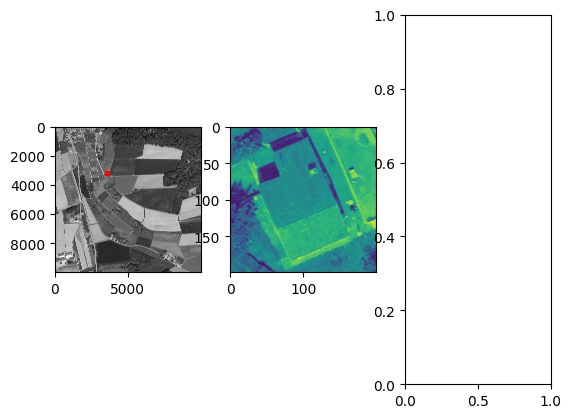

In [18]:
from pyproj import Transformer
import rasterio, rasterio.features, rasterio.warp
from rasterio.windows import Window
import cv2

transformer_to_wgs = Transformer.from_crs("EPSG:2056", "EPSG:4326")
transformer_to_lv95 = Transformer.from_crs("EPSG:4326", "EPSG:2056")

walls2D = wallsNS2D + wallsWE2D
wallsx, wallsy = [],[]
wallsxt, wallsyt = [],[]

for i in range(len(walls2D)):
    if(i%2==0):
        wallsx.append(walls2D[i]+lon_kml)
    else:
        wallsy.append(walls2D[i]+lat_kml)

for x, y in zip(wallsx, wallsy):
    yt, xt = transformer_to_lv95.transform(y, x)
    wallsxt.append(xt)
    wallsyt.append(yt)

minx, maxx, miny, maxy=min(wallsxt), max(wallsxt), min(wallsyt), max(wallsyt)

print(minx, maxx, miny, maxy)



xlv95, ylv95 = transformer_to_lv95.transform(lat, lon)
xlv95, ylv95 = int(xlv95/1000), int(ylv95/1000)

roof_Polygon = []
roof_image = None

for tif in os.listdir("swissImage"):
    if tif == 'swissimage-dop10_2022_{x}-{y}_0.1_2056.tif'.format(x=xlv95, y=ylv95):
        aerial_image = tif
        break

xlv95, ylv95 = transformer_to_lv95.transform(lat_kml, lon_kml)
xlv95, ylv95 = round(xlv95,2), round(ylv95,2)

print(lat_kml, lon_kml)
print(xlv95, ylv95)



with rasterio.open("swissImage\\"+aerial_image) as src:
    xtif, ytif = src.index(xlv95, ylv95)
    print(xtif, ytif)

    window_size = 200
    window = src.read(window=Window(ytif-window_size/2, xtif-window_size/2,window_size, window_size))
    window_cut=src.read(window=Window(ytif-(ytif-miny), xtif-(xtif-minx), maxx-minx, maxy-miny))
    image_array=src.read(1)

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
    plt.plot([ytif, ytif+window_size], [xtif, xtif], 'r')
    plt.plot([ytif, ytif], [xtif, xtif+window_size], 'r')
    plt.plot([ytif+window_size, ytif+window_size], [xtif, xtif+window_size], 'r')
    plt.plot([ytif, ytif+window_size], [xtif+window_size, xtif+window_size], 'r')
    plt.subplot(1,3,2)
    plt.imshow(window[0])
    plt.subplot(1,3,3)

    #plt.show()

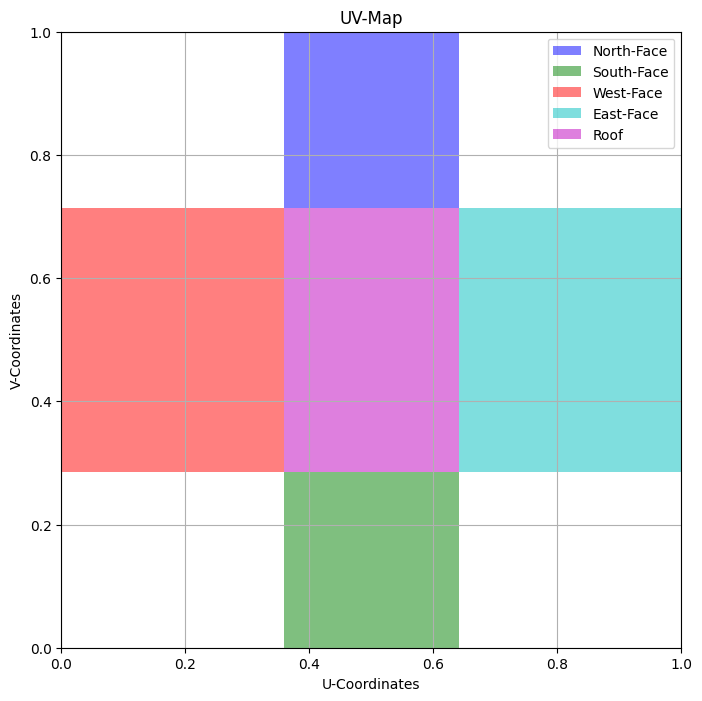

In [19]:
#Create UV-Map
from math import sqrt


zmin_n, zmax_n = None, None
xmin_n, xmax_n = None, None
ymin_n, ymax_n = None, None
for i in range(0,len(n_walls[0].vertices),9):
    x1, y1, z1, x2, y2, z2, x3, y3, z3 = n_walls[0].vertices[i], n_walls[0].vertices[i+1], n_walls[0].vertices[i+2], n_walls[0].vertices[i+3], n_walls[0].vertices[i+4], n_walls[0].vertices[i+5], n_walls[0].vertices[i+6], n_walls[0].vertices[i+7], n_walls[0].vertices[i+8]
    if i==0:
        zmin_n, zmax_n = min(z1, z2, z3), max(z1, z2, z3)
        xmin_n, xmax_n = min(x1, x2, x3), max(x1, x2, x3)
        ymin_n, ymax_n = min(y1, y2, y3), max(y1, y2, y3)
    else:
        zmin_n, zmax_n = min(zmin_n, z1, z2, z3), max(zmax_n, z1, z2, z3)
        xmin_n, xmax_n = min(xmin_n, x1, x2, x3), max(xmax_n, x1, x2, x3)
        ymin_n, ymax_n = min(ymin_n, y1, y2, y3), max(ymax_n, y1, y2, y3)
len_wall_n = sqrt((xmax_n-xmin_n)**2 + (ymax_n-ymin_n)**2)
height_wall_n = zmax_n-zmin_n

zmin_s, zmax_s = None, None
xmin_s, xmax_s = None, None
ymin_s, ymax_s = None, None
for i in range(0,len( s_walls[0].vertices),9):
    x1, y1, z1, x2, y2, z2, x3, y3, z3 = s_walls[0].vertices[i], s_walls[0].vertices[i+1], s_walls[0].vertices[i+2], s_walls[0].vertices[i+3], s_walls[0].vertices[i+4], s_walls[0].vertices[i+5], s_walls[0].vertices[i+6], s_walls[0].vertices[i+7], s_walls[0].vertices[i+8]
    if i==0:
        zmin_s, zmax_s = min(z1, z2, z3), max(z1, z2, z3)
        xmin_s, xmax_s = min(x1, x2, x3), max(x1, x2, x3)
        ymin_s, ymax_s = min(y1, y2, y3), max(y1, y2, y3)
    else:
        zmin_s, zmax_s = min(zmin_s, z1, z2, z3), max(zmax_s, z1, z2, z3)
        xmin_s, xmax_s = min(xmin_s, x1, x2, x3), max(xmax_s, x1, x2, x3)
        ymin_s, ymax_s = min(ymin_s, y1, y2, y3), max(ymax_s, y1, y2, y3)
len_wall_s = sqrt((xmax_s-xmin_s)**2 + (ymax_s-ymin_s)**2)
height_wall_s = zmax_s-zmin_s

zmin_w, zmax_w = None, None
xmin_w, xmax_w = None, None
ymin_w, ymax_w = None, None
for i in range(0,len(w_walls[0].vertices),9):
    x1, y1, z1, x2, y2, z2, x3, y3, z3 = w_walls[0].vertices[i], w_walls[0].vertices[i+1], w_walls[0].vertices[i+2], w_walls[0].vertices[i+3], w_walls[0].vertices[i+4], w_walls[0].vertices[i+5], w_walls[0].vertices[i+6], w_walls[0].vertices[i+7], w_walls[0].vertices[i+8]
    if i==0:
        zmin_w, zmax_w = min(z1, z2, z3), max(z1, z2, z3)
        xmin_w, xmax_w = min(x1, x2, x3), max(x1, x2, x3)
        ymin_w, ymax_w = min(y1, y2, y3), max(y1, y2, y3)
    else:
        zmin_w, zmax_w = min(zmin_w, z1, z2, z3), max(zmax_w, z1, z2, z3)
        xmin_w, xmax_w = min(xmin_w, x1, x2, x3), max(xmax_w, x1, x2, x3)
        ymin_w, ymax_w = min(ymin_w, y1, y2, y3), max(ymax_w, y1, y2, y3)
len_wall_w = sqrt((xmax_w-xmin_w)**2 + (ymax_w-ymin_w)**2)
height_wall_w = zmax_w-zmin_w

zmin_e, zmax_e = None, None
xmin_e, xmax_e = None, None
ymin_e, ymax_e = None, None
for i in range(0,len(e_walls[0].vertices),9):
    x1, y1, z1, x2, y2, z2, x3, y3, z3 = e_walls[0].vertices[i], e_walls[0].vertices[i+1], e_walls[0].vertices[i+2], e_walls[0].vertices[i+3], e_walls[0].vertices[i+4], e_walls[0].vertices[i+5], e_walls[0].vertices[i+6], e_walls[0].vertices[i+7], e_walls[0].vertices[i+8]
    if i==0:
        zmin_e, zmax_e = min(z1, z2, z3), max(z1, z2, z3)
        xmin_e, xmax_e = min(x1, x2, x3), max(x1, x2, x3)
        ymin_e, ymax_e = min(y1, y2, y3), max(y1, y2, y3)
    else:
        zmin_e, zmax_e = min(zmin_e, z1, z2, z3), max(zmax_e, z1, z2, z3)
        xmin_e, xmax_e = min(xmin_e, x1, x2, x3), max(xmax_e, x1, x2, x3)
        ymin_e, ymax_e = min(ymin_e, y1, y2, y3), max(ymax_e, y1, y2, y3)
len_wall_e = sqrt((xmax_e-xmin_e)**2 + (ymax_e-ymin_e)**2)
height_wall_e = zmax_e-zmin_e

total_width = 2*max(height_wall_w, height_wall_e) + max(len_wall_n, len_wall_s)
total_height = 2*max(height_wall_n,height_wall_s) + max(len_wall_e, len_wall_w)

#Create UV-Map
uvmap = np.zeros((5, 4, 2), dtype=np.float32)

#North-Face
uvmap[0] = np.array([[(1/total_width)*max(height_wall_w, height_wall_e), (1/total_height)*(max(height_wall_n,height_wall_s)+max(len_wall_w, len_wall_e))], [(1/total_width)*(max(height_wall_w, height_wall_e)+max(len_wall_n, len_wall_s)), (1/total_height)*(max(height_wall_n,height_wall_s)+max(len_wall_w, len_wall_e))], [(1/total_width)*(max(height_wall_w, height_wall_e)+max(len_wall_n, len_wall_s)), 1.0], [(1/total_width)*max(height_wall_w, height_wall_e), 1.0]], dtype=np.float32)
#South-Face
uvmap[1] = np.array([[(1/total_width)*max(height_wall_w, height_wall_e), 0.0], [(1/total_width)*(max(height_wall_w, height_wall_e)+max(len_wall_n, len_wall_s)), 0.0], [(1/total_width)*(max(height_wall_w, height_wall_e)+max(len_wall_n, len_wall_s)), (1/total_height)*max(height_wall_n,height_wall_s)], [(1/total_width)*max(height_wall_w, height_wall_e), (1/total_height)*max(height_wall_n,height_wall_s)]], dtype=np.float32)
#West-Face
uvmap[2] = np.array([[0.0, (1/total_height)*max(height_wall_n,height_wall_s)],[(1/total_width)*max(height_wall_w, height_wall_e), (1/total_height)*max(height_wall_n,height_wall_s)], [(1/total_width)*max(height_wall_w, height_wall_e), (1/total_height)*(max(height_wall_n,height_wall_s)+max(len_wall_w, len_wall_e))],  [0.0, (1/total_height)*(max(height_wall_n,height_wall_s)+max(len_wall_w, len_wall_e))]], dtype=np.float32)
#East-Face
uvmap[3] = np.array([[(1/total_width)*(max(height_wall_w, height_wall_e)+max(len_wall_n, len_wall_s)), (1/total_height)*max(height_wall_n,height_wall_s)], [1.0, (1/total_height)*max(height_wall_n,height_wall_s)], [1.0, (1/total_height)*(max(height_wall_n,height_wall_s)+max(len_wall_w, len_wall_e))], [(1/total_width)*(max(height_wall_w, height_wall_e)+max(len_wall_n, len_wall_s)), (1/total_height)*(max(height_wall_n,height_wall_s)+max(len_wall_w, len_wall_e))]], dtype=np.float32)
#Roof-max(height_wall_n,height_wall_s)
uvmap[4] = np.array([[(1/total_width)*max(height_wall_w, height_wall_e), (1/total_height)*max(height_wall_n,height_wall_s)], [(1/total_width)*(max(height_wall_w, height_wall_e)+max(len_wall_n, len_wall_s)), (1/total_height)*max(height_wall_n,height_wall_s)], [(1/total_width)*(max(height_wall_w, height_wall_e)+max(len_wall_n, len_wall_s)), (1/total_height)*(max(height_wall_n,height_wall_s)+max(len_wall_w, len_wall_e))], [(1/total_width)*max(height_wall_w, height_wall_e), (1/total_height)*(max(height_wall_n,height_wall_s)+max(len_wall_w, len_wall_e))]], dtype=np.float32)

plt.figure(figsize=(8, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Different colors for each face
label = ['North-Face', 'South-Face', 'West-Face', 'East-Face', 'Roof']

for i in range(0, len(uvmap)):
    plt.fill(uvmap[i][:, 0], uvmap[i][:, 1], colors[i], alpha=0.5, label=label[i])

plt.title('UV-Map')
plt.xlabel('U-Coordinates')
plt.ylabel('V-Coordinates')
plt.legend()

plt.xlim(0,1)
plt.ylim(0,1)

plt.grid(True)
plt.show()


In [20]:
import subprocess
import os

# Check if blender file already exists
working_dir = os.getcwd()
collada_file = os.path.join("swissBUILDINGS3D", kml, "models", model)
file_name = os.path.splitext(os.path.basename(collada_file))[0]
blend_file = os.path.join(working_dir,os.path.dirname(collada_file), file_name + "_with_uv_map.blend")

if os.path.exists(blend_file):
    os.remove(blend_file)
    print("Removed existing Blender file")

# Run Blender with the script
result = subprocess.run(["blender", "-P", "create_uv.py", "--", model, kml], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Check if there was an error
if result.returncode != 0:
    print("Blender execution failed with the following output:")
    print(result.stdout)
    print(result.stderr)
else:
    print("Blender execution succeeded!")


Removed existing Blender file
Blender execution succeeded!


## PLEASE EDIT ADD TEXTURES TO THE UV-MAP AND SAVE THE FILE AS filename_texture.png WHERE FILENAME IS THE NAME OF THE MODEL

In [22]:
# Check if blender file already exists
working_dir = os.getcwd()
collada_file = os.path.join("swissBUILDINGS3D", kml, "models", model)
file_name = os.path.splitext(os.path.basename(collada_file))[0]
blend_file = os.path.join(working_dir,os.path.dirname(collada_file), file_name + "_texturated.blend")

if os.path.exists(blend_file):
    os.remove(blend_file)
    print("Removed existing Blender file")

# Run Blender with the script
result = subprocess.run(["blender", "-P", "texturing.py", "--", model, kml], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Check if there was an error
if result.returncode != 0:
    print("Blender execution failed with the following output:")
    print(result.stdout)
    print(result.stderr)
    print("If the error is EXCEPTION_ACCESS_VIOLATION, the script will have worked. Check the output file.")
else:
    print("Blender execution succeeded!")


Removed existing Blender file
Blender execution failed with the following output:
Read prefs: "C:\Users\chu\AppData\Roaming\Blender Foundation\Blender\4.0\config\userpref.blend"
Read blend: "c:\Users\chu\Documents\Studium\Bachelorarbeit\swissBUILDINGS3D\1052-11\models\model_2045_with_uv_map.blend"
Info: Saved "model_2045_texturated.blend"
Writing: C:\Users\chu\AppData\Local\Temp\model_2045_texturated.crash.txt

Error   : EXCEPTION_ACCESS_VIOLATION
Address : 0x00007FF6468E5355
Module  : blender.exe
Thread  : 00005eb8

